# Coding Challange for Cohort 25 and 26(Fellowship.ai)
Do a thorough Exploratory Data Analysis of the dataset and report the final performance metrics for your approach. Suggest ways in which you can improve the model.

- solved by sudip pokhrel

### NLP Challenge: IMDB Dataset of 50K Movie Reviews to perform Sentiment analysis

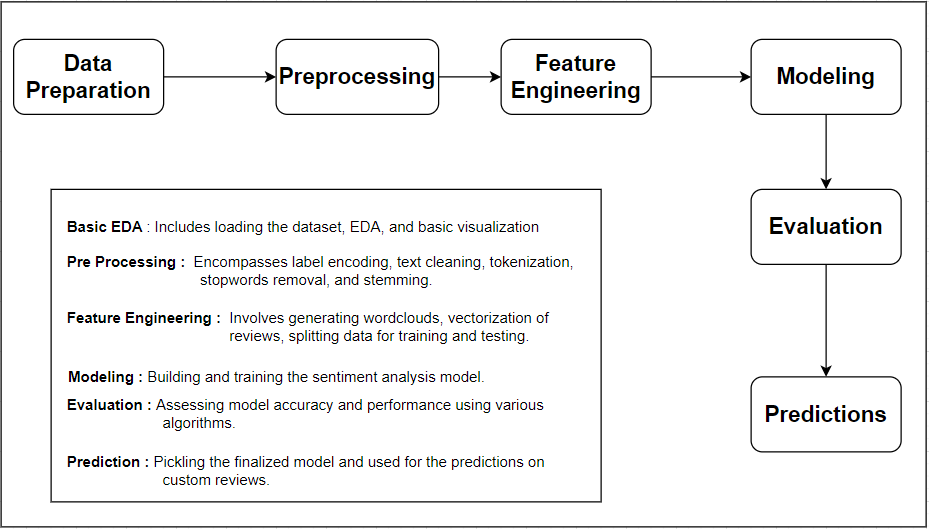

### Solution

**import Libraries**


In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

import pickle


**1.Load the dataset and creating dataframe**

In [2]:
file = 'data/IMDB Dataset.csv'
df= pd.read_csv(file)


## Exploratory Data Analysis(EDA)

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


**Class Distribution**

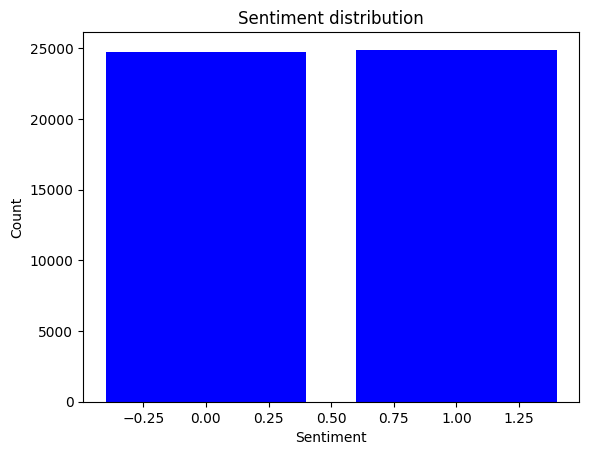

In [195]:
class_counts = df['sentiment'].value_counts()
#print(class_counts.index,class_counts.values)
# Plot the class distribution
plt.bar(class_counts.index, class_counts.values,color='blue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment distribution')
plt.show()

In [5]:
df.describe(include=['object'])

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
df.nunique()

review       49582
sentiment        2
dtype: int64

In [7]:
duplicated_count = df.duplicated().sum()
print("Number of duplicate entries: ", duplicated_count)

Number of duplicate entries:  418


In [8]:
# drop duplicate values
df = df.drop_duplicates('review')


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


**Adding Column Word Count**

In [10]:
def no_of_words(text):
    if isinstance(text, list):
        word_count = len(text)
    else:
        words = text.split()
        word_count = len(words)
    return word_count


In [11]:
df['word count'] = df['review'].apply(no_of_words)
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


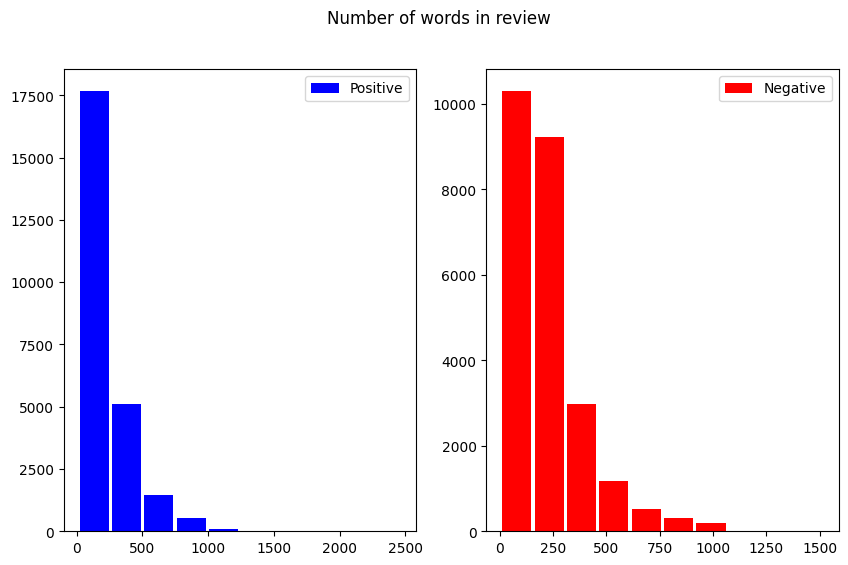

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 'positive']['word count'], label='Positive', color='blue', rwidth=0.9);
ax[0].legend(loc='upper right');
ax[1].hist(df[df['sentiment'] == 'negative']['word count'], label='Negative', color='red', rwidth=0.9);
ax[1].legend(loc='upper right');
fig.suptitle("Number of words in review")
plt.show()

### Label Encoding
Label Encoding is a technique that is used to convert categorical columns into numerical ones so that they can be fitted by machine learning models which only take numerical data.

In [13]:
from sklearn import preprocessing 
  
# label_encoder object knows  
# how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df['sentiment']= label_encoder.fit_transform(df['sentiment']) 

In [14]:
df['sentiment'].head(5)

0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int32

In [15]:
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,1,162
2,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230


## Data Preprocessing

### Remove all special and numeric character from data and also remove stopwards and apply stemming

In [196]:
def data_processing(text):
    text = text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

### Tokenization & Removing Stop Words
- **Tokenization**: the process of breaking down the text into individual words or tokens.<br>
- **stop words** :  refers to a predefined list of common words that are usually filtered out during natural language processing1. These are words that do not contain important meaning and are usually removed from texts. They include words such as “is”, “an”, “the”, “and”, etc

In [17]:
def tokenize(text):
    text_tokens = word_tokenize(text)
    return text_tokens

def remove_stopwords(text_tokens):
    stop_words = set(stopwords.words('english'))
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)



In [18]:
# Update the tokenized data 
df['review'] = df['review'].apply(data_processing)
df['review'] = df['review'].apply(tokenize)
df['review'] = df['review'].apply(remove_stopwords)

### Stemming words with NLTK
Stemming is the process of producing morphological variants of a root/base word. Stemming programs are commonly referred to as stemming algorithms or stemmers. A stemming algorithm reduces the words “chocolates”, “chocolatey”, and “choco” to the root word, “chocolate” and “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”.

In [19]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [20]:
df.review = df['review'].apply(lambda x: stemming(x))

In [21]:
df['word count'] = df['review'].apply(no_of_words)
df.head()

,review,sentiment,word count
0,one reviewers mentioned watching 1 oz episode ...,1,168
1,wonderful little production filming technique ...,1,84
2,thought wonderful way spend time hot summer we...,1,86
3,basically theres family little boy jake thinks...,0,67
4,petter matteis love time money visually stunni...,1,125


## Positive Reviews analysis

In [22]:
positive_reviews =  df[df.sentiment == 1]
positive_reviews.head()

,review,sentiment,word count
0,one reviewers mentioned watching 1 oz episode ...,1,168
1,wonderful little production filming technique ...,1,84
2,thought wonderful way spend time hot summer we...,1,86
4,petter matteis love time money visually stunni...,1,125
5,probably alltime favorite movie story selfless...,1,58


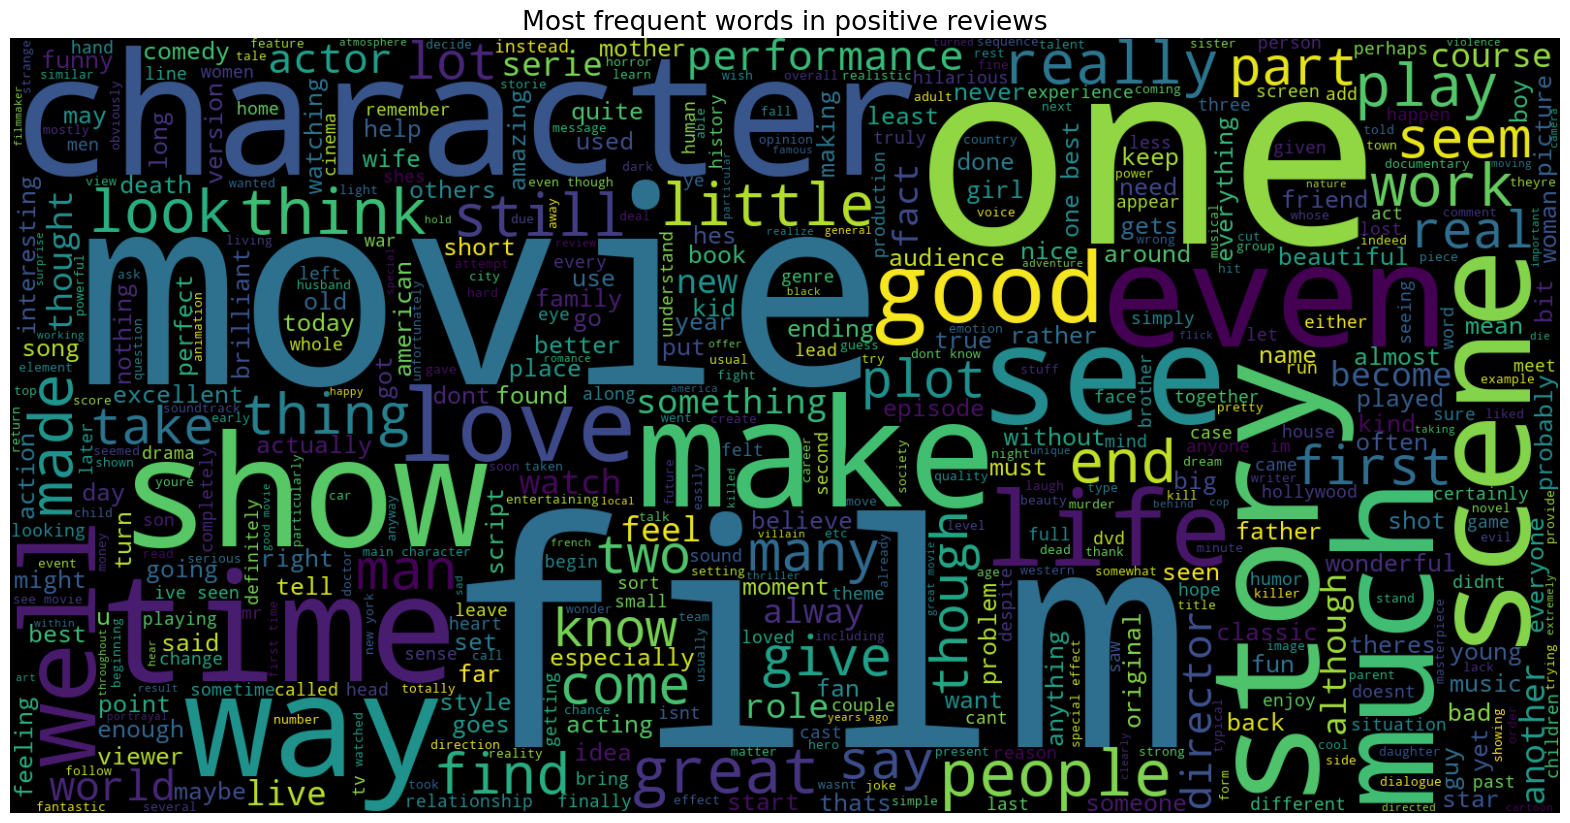

In [23]:
text = ' '.join([word for word in positive_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

In [24]:
count = Counter()
for text in positive_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('film', 39285),
 ('movie', 35836),
 ('one', 25621),
 ('like', 16999),
 ('good', 14286),
 ('great', 12570),
 ('story', 12338),
 ('see', 11814),
 ('time', 11724),
 ('well', 10933),
 ('really', 10641),
 ('also', 10517),
 ('would', 10320),
 ('even', 9319),
 ('much', 8971)]

In [25]:
positive_words = pd.DataFrame(count.most_common(15))
positive_words.columns = ['word', 'count']
positive_words.head()

,word,count
0,film,39285
1,movie,35836
2,one,25621
3,like,16999
4,good,14286


In [27]:
px.bar(positive_words, y='count', x='word', title='Common words in positive reviews')

### Negative Review Analysis

In [28]:
negative_reviews =  df[df.sentiment == 0]
negative_reviews.head()

,review,sentiment,word count
3,basically theres family little boy jake thinks...,0,67
7,show amazing fresh innovative idea 70s first a...,0,83
8,encouraged positive comments film looking forw...,0,64
10,phil alien one quirky films humour based aroun...,0,51
11,saw movie 12 came recall scariest scene big bi...,0,84


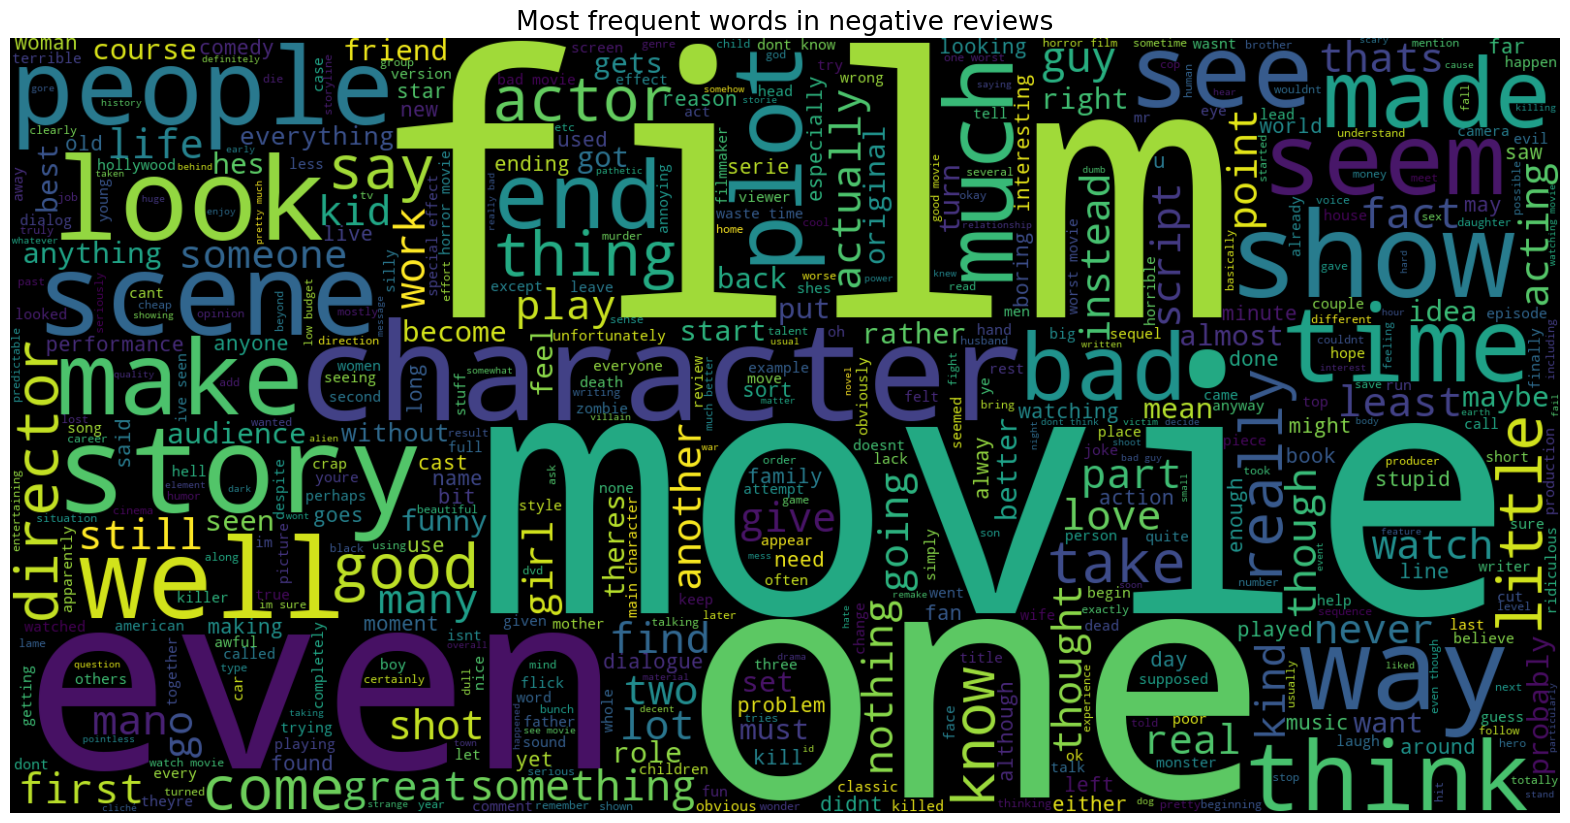

In [29]:
text = ' '.join([word for word in negative_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negative reviews', fontsize = 19)
plt.show()

In [30]:
count = Counter()
for text in negative_reviews['review'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('movie', 47011),
 ('film', 34651),
 ('one', 24364),
 ('like', 21509),
 ('even', 14761),
 ('good', 13997),
 ('bad', 13906),
 ('would', 13483),
 ('really', 12084),
 ('time', 11350),
 ('see', 10413),
 ('dont', 9912),
 ('get', 9884),
 ('much', 9759),
 ('story', 9564)]

In [31]:
negative_words = pd.DataFrame(count.most_common(15))
negative_words.columns = ['word', 'count']
negative_words.head()

,word,count
0,movie,47011
1,film,34651
2,one,24364
3,like,21509
4,even,14761


In [34]:
px.bar(negative_words, y='count', x='word', title='Common words in negative reviews', color = 'word')

### Divide The data into independent and dependent

In [73]:
x = df['review']
Y = df['sentiment']

### Vectorization
Vectorization in machine learning refers to the process of converting data into arrays of numerical values, known as vectors. This is typically done to speed up the processing time of machine learning algorithms, as many of these algorithms are designed to operate on numerical data in vector form.
- TfidfVectorizer() is used below to 


In [77]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import train_test_split

# Initialize the TF-IDF vectorizer
vect = TfidfVectorizer()

# Fit the vectorizer to the data
X = vect.fit_transform(df['review'])



## Model Building


### Splitting the data into training and testing set

In [90]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25, random_state=10)

In [91]:
print("Size of x_train: ", (X_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (X_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (37186, 221707)
Size of y_train:  (37186,)
Size of x_test:  (12396, 221707)
Size of y_test:  (12396,)


In [92]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import LinearSVC
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import warnings
# warnings.filterwarnings('ignore')

### Using Various Algorithms to build a model

#### 1. Logistic Regression

In [107]:
# Logistic Regression algorithm 
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy of Logistic Regression Model is : {:.2f}%".format(logreg_acc*100))

Test accuracy of Logistic Regression Model is : 89.29%


In [111]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[5483  742]
 [ 585 5586]]


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6225
           1       0.88      0.91      0.89      6171

    accuracy                           0.89     12396
   macro avg       0.89      0.89      0.89     12396
weighted avg       0.89      0.89      0.89     12396



#### 2. Multinomial naive Bayes

In [108]:
# Multinomial naive Bayes algorithm
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb_pred = mnb.predict(X_test)
mnb_acc = accuracy_score(mnb_pred, y_test)
print("Test accuracy of Multinomial naive Bayes model is : {:.2f}%".format(mnb_acc*100))

Test accuracy of Multinomial naive Bayes model is : 86.82%


In [113]:
print(confusion_matrix(y_test, mnb_pred))
print("\n")
print(classification_report(y_test, mnb_pred))



[[5426  799]
 [ 835 5336]]


              precision    recall  f1-score   support

           0       0.87      0.87      0.87      6225
           1       0.87      0.86      0.87      6171

    accuracy                           0.87     12396
   macro avg       0.87      0.87      0.87     12396
weighted avg       0.87      0.87      0.87     12396



#### 3. Linear Support Vector classifier


In [109]:
#Linear Support Vector Classifier
svc = LinearSVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Test accuracy of Linear Support Vector Classifier model is : {:.2f}%".format(svc_acc*100))

Test accuracy of Linear Support Vector Classifier model is : 89.64%


In [114]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[5533  692]
 [ 589 5582]]


              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6225
           1       0.89      0.90      0.90      6171

    accuracy                           0.90     12396
   macro avg       0.90      0.90      0.90     12396
weighted avg       0.90      0.90      0.90     12396



In [100]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.1, 1, 10, 100], 'loss':['hinge', 'squared_hinge']}
grid = GridSearchCV(svc, param_grid, refit=True, verbose = 3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................C=0.1, loss=hinge;, score=0.884 total time=   0.0s
[CV 2/5] END .................C=0.1, loss=hinge;, score=0.878 total time=   0.1s
[CV 3/5] END .................C=0.1, loss=hinge;, score=0.878 total time=   0.0s
[CV 4/5] END .................C=0.1, loss=hinge;, score=0.877 total time=   0.1s
[CV 5/5] END .................C=0.1, loss=hinge;, score=0.876 total time=   0.1s
[CV 1/5] END .........C=0.1, loss=squared_hinge;, score=0.895 total time=   0.2s
[CV 2/5] END .........C=0.1, loss=squared_hinge;, score=0.893 total time=   0.2s
[CV 3/5] END .........C=0.1, loss=squared_hinge;, score=0.893 total time=   0.1s
[CV 4/5] END .........C=0.1, loss=squared_hinge;, score=0.894 total time=   0.2s
[CV 5/5] END .........C=0.1, loss=squared_hinge;, score=0.891 total time=   0.2s
[CV 1/5] END ...................C=1, loss=hinge;, score=0.897 total time=   1.9s
[CV 2/5] END ...................C=1, loss=hinge;,

GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'loss': ['hinge', 'squared_hinge']},
             verbose=3)

In [101]:
print("best cross validation score: {:.2f}".format(grid.best_score_))
print("best parameters: ", grid.best_params_)

best cross validation score: 0.90
best parameters:  {'C': 1, 'loss': 'hinge'}


In [110]:
svc = LinearSVC(C = 1, loss='hinge')
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Test accuracy of LinearSVC: {:.2f}%".format(svc_acc*100))

Test accuracy of LinearSVC: 89.67%


In [115]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[5533  692]
 [ 589 5582]]


              precision    recall  f1-score   support

           0       0.90      0.89      0.90      6225
           1       0.89      0.90      0.90      6171

    accuracy                           0.90     12396
   macro avg       0.90      0.90      0.90     12396
weighted avg       0.90      0.90      0.90     12396



### Save My trained (best) Model and Tfid Vectorizer

In [123]:
# open a file, where you ant to store the data
file_vect = open("count-Vectorizer.pkl", "wb")
file_model = open("Movie_review_classification.pkl", "wb")

# dump information to that file
pickle.dump(vect, file_vect )
pickle.dump(svc,file_model )


#### Load that model

In [124]:
# Load the vectorizer and the model from disk
vectorizer = pickle.load(open("count-Vectorizer.pkl", "rb"))
model = pickle.load(open("Movie_review_classification.pkl", "rb"))


## Using That model to predict the new Reviews

##### defining function to test model

In [190]:
def predict_sentiment(review):
    # Preprocess the review
    review = data_processing(review)
    
    # Tokenize and remove stop words
    review = tokenize(review)
    review = remove_stopwords(review)
      #print("Review after stopwords", review)
    
    
    # Convert the review to a matrix of TF-IDF features
    #sen = vectorizer.transform([' '.join(review)])
      #print("Review after stopwords",sen )
    sen = vectorizer.transform([review])    
    
    # Use the model to predict the sentiment of the review
    y_pred = model.predict(sen)
    
    # Return the predicted sentiment
    return 'Positive' if y_pred[0] == 1 else 'Negative'    
    
    

##### Sending inputs to test

In [193]:
# Positive input
sen = "it is the best movie i have ever seen"
res = predict_sentiment(sen)
print(res)

Positive


In [194]:
#Negative Inputs
sen = "The movie was horrible, i couldn't understand the characters representation"
res = predict_sentiment(sen)
print(res)

Negative


### The model could be deployed using flask